# Geologic profiles with pygsf

*Doc started 2019-05-12*

*Current version: 2019-09-14*

This notebook describes the calculation of topographic profiles. As input data we need a DEM and a profile. 

Figures are plotted via matplotlib:

In [1]:
%matplotlib inline

Data sets can be plotted with pprint:

In [2]:
from pprint import pprint

## 1-  Mount Alpi (Lucania, Southern Italy)

### DEM input

The source DEM derives from publicly available Aster data and refers to the the Mt. Alpi zone (Lucania, Southern Italy):

In [3]:
source_data = "/home/mauro/Documents/projects/gsf/example_data/mt_alpi/malpi_aster_w4u3.tif"

We read the DEM using a wrapper function to GDAL:

In [4]:
from pygsf.spatial.rasters.io import read_raster_band
success, result = read_raster_band(raster_source=source_data, epsg_cd = 32633)

In [5]:
print(success, result)

True GeoArray with 1 band(s) - CRS: EPSG: 32633

Band 1: 260 rows x 213 cols; min: 0.0,  max: 1829.0


The DEM projection is UTM zone 33 N. We plot it.

In [6]:
geoarray = result

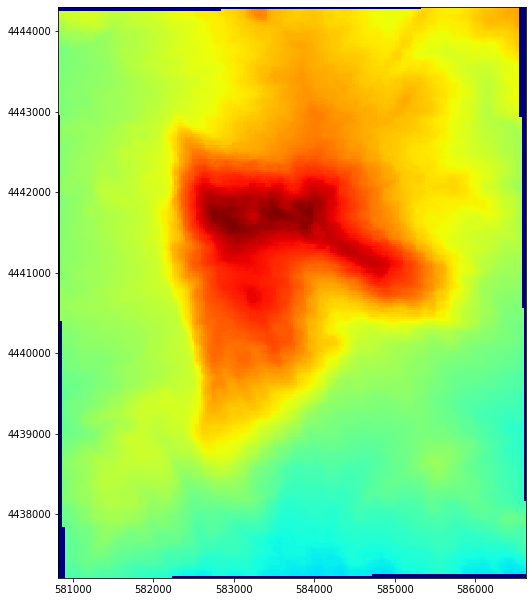

In [7]:
from pygsf.utils.maps.plot import plot_grid
fig = plot_grid(geoarray)

### Source profile

Now we read the source profile from a line shapefile. It is a single line, projected in WGS 84 - UTM 33 N.

In [8]:
src_profile_shapefile_pth = "/home/mauro/Documents/projects/gsf/example_data/mt_alpi/profile.shp"

In [9]:
from pygsf.spatial.vectorial.io import read_linestring_geometries
profiles = read_linestring_geometries(src_profile_shapefile_pth)
print(profiles)

MultiLine with 1 line(s) and 2 total point(s) - EPSG: 32633


This *MultiLine* instance contains a single line, that is made up by two points.
The spatial reference of the line profile is the same as the raster DEM: WGS1984 - UTM 33 N. 
So no projection conversion is required to calculate the profile.

Now we extract the profile line and add it in the previous map.

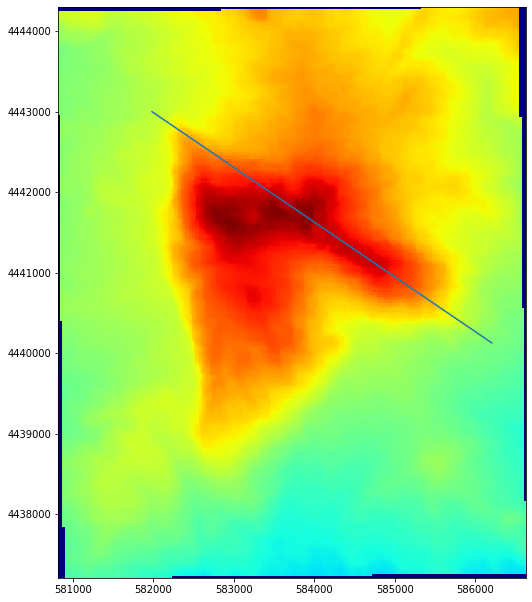

In [10]:
line = profiles.line()
from pygsf.utils.maps.plot import plot_line
plot_line(fig, line)

### Initializing a geoprofile

The *geoprofile* is the unitary container for our topographic and geological data related to a single geological profiles. It is initialized as an empty geoprofile, to which content will be added in subsequent steps.

In [11]:
from pygsf.spatial.geology.profiles.geoprofiles import GeoProfile
geoprofile = GeoProfile()

### Creating a linear profiler

To extract the topographic and geologic elements from the various data source, we make use of the *linear profiler*.
The data extracted will then be added to the *geoprofile*. 

We generate a *linear profiler*, with a spacing of 5 meters along the profile, by making use of the *LinearProfiler* class in the *geoprocess* module.

In [12]:
from pygsf.spatial.geology.profiles.profilers import LinearProfiler
profiler = LinearProfiler(start_pt=line.start_pt(), end_pt=line.end_pt(), densify_distance= 5)

In [13]:
profiler

LinearProfiler(
	start_pt = Point(581981.1880, 4442999.2144, 0.0000, 0.0000, 32633),
	end_pt = Point(586203.5723, 4440126.1905, 0.0000, 0.0000, 32633),
	densify_distance = 5.0)

In [14]:
profiler.num_pts()

1023

The number of points making up the profile is slightly more than a thousand.

### Adding a topographic profile

Now we create and plot a vertical topographic profile using as elevation data source the previously defined DEM. 

In [15]:
topo_profile = profiler.profile_grid(geoarray)
print("Type of 'topo_profile': {}".format(type(topo_profile)))

Type of 'topo_profile': <class 'pygsf.spatial.geology.profiles.chains.TopographicProfile'>


The variable *topo_profile* is an instance of <*geoprocess.profiles.base.ScalarProfiles*>. 
The *Scalar* prefix to *Profiles* means that scalar values (f.i., elevations) are stored in the profile(s).

Since we used just one grid as a parameter for the *profile_grids* method, there is a single topographic profile stored in the variable.

Now we add the topographic profile to the geological profile:

In [16]:
geoprofile.topo_profile = topo_profile

And then plot it:

Creating topography profile


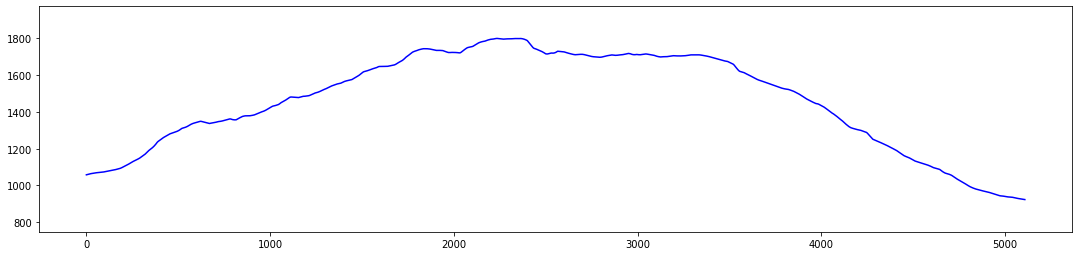

In [17]:
from pygsf.spatial.geology.profiles.plot import plot
fig = plot(geoprofile)

### Geological attitudes plot

We extract geological attitudes from a shapefile:

In [18]:
attitudes_shape = "/home/mauro/Documents/projects/gsf/example_data/mt_alpi/attitudes.shp"

We use the *geopandas* module to read the data. It will create a *geopandas.GeoDataFrame* instance.

In [19]:
import geopandas
attitudes = geopandas.read_file(attitudes_shape)
attitudes

,Id,dip_dir,dip_ang,Formation,type,geometry
0,1,90.0,18.0,Mesozoic limestones,stratification,POINT (583531.375 4441614.401)
1,2,95.0,30.0,Miocenic conglomerates,stratification,POINT (583771.704 4441895.090)
2,3,72.0,26.0,Miocenic calcarenites,stratification,POINT (584184.366 4441269.220)
3,4,75.0,40.0,Mesozoic limestones,stratification,POINT (584722.156 4441071.520)
4,5,80.0,15.0,Mesozoic limestones,stratification,POINT (582878.687 4442105.863)
5,6,60.0,25.0,Miocenic calcarenites,stratification,POINT (584266.849 4441208.758)
6,7,30.0,15.0,Mesozoic limestones,stratification,POINT (584249.684 4441182.484)
7,8,70.0,35.0,Mesozoic limestones,stratification,POINT (584838.631 4440925.733)
8,9,105.0,40.0,Mesozoic limestones,stratification,POINT (584644.096 4441353.934)
9,10,135.0,21.0,Miocenic arenites and conglomerates,stratification,POINT (585641.114 4440448.176)


In [20]:
attitudes.crs

{'init': 'epsg:32633'}

The projection of the source dataset is UTM33, as are the DEM and the profile, so we do not need any reprojection.

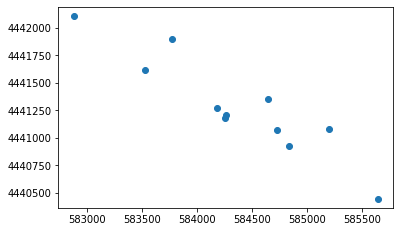

In [21]:
ax = attitudes.plot()

We get the relevant infos from the geodataframe. We do not provide any name for the id field name in the *extract_georeferenced_attitudes* function, so the id will be simple a progressive counter. Otherwise the id would be red by the provided field name.

In [24]:
from pygsf.spatial.geology.convert import try_extract_georeferenced_attitudes
attitudes = try_extract_georeferenced_attitudes(
    geodataframe = attitudes, 
    azim_fldnm = "dip_dir", 
    dip_ang_fldnm = "dip_ang")

In [25]:
print("Number of attitudes: {}".format(len(attitudes)))

Number of attitudes: 2


In [26]:
pprint(attitudes)

(False, "'tuple' object has no attribute 'crs'")


A georeferenced attitude is defined by its *id*, *postion* and *attitude*. We note that the points are 2D, since their elevation value, i.e., their third Cartesian coordinate, is always zero (the fourth coordinate is time and the last is the EPSG numeric code). Their elevation will be automatically extracted from the DEM in the following steps by choosing a *height_source* parameter in the *map_georef_attitudes_to_section* method.

Having converted the data in a suitable format (i.e., *GeorefAttitude*), now we calculate the projections of the attitude on the section:

In [28]:
mapping_method = {}
mapping_method['method'] = 'nearest'
att_projs = profiler.map_georef_attitudes_to_section(
            attitudes_3d = attitudes,
            mapping_method = mapping_method)
            

Exception: Georef attitude should be GeorefAttitude but is <class 'bool'>

In [ ]:
pprint(att_projs)

Resulting profile attitudes are automatically sorted by their increasing distance along the profile. The main fields are:
- *id*: identifier inherited from the georeferenced attitudes, 
- *s*: the distance of the projected attitude along the profile (may be negative or exceeed the profile length),  
- *z*: the elevation, 
- *slope_degr*: the resulting slope, in degrees, 
- *down_sense*: describes whether the plane plunges to the right or to the left, 
- *dist*: the distance between the original attitude location and its projection (according to the chosen method) on the profile plane.

In [ ]:
geoprofile.attitudes = att_projs

In [ ]:
fig = plot(geoprofile)

## 2 - Timpa San Lorenzo area (Calabria, Southern Italy)

Now we move around 35 km to the South-East of the Mt. Alpi are, and consider the Timpa San Lorenzo area, in Calabria, East of Mt. Pollino range.

Source data are a TinItaly DEM, in addition to a base profile.

In [ ]:
src_dem = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/tsl_tinitaly_w84u32.tif"
src_profile = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/profile.shp"

In [ ]:
success, result = read_raster_band(raster_source=src_dem, epsg_cd = 32632)

In [ ]:
print(success, result)

In [ ]:
geoarray = result

In [ ]:
fig = plot_grid(geoarray)

In [ ]:
profiles = read_linestring_geometries(src_profile)
line = profiles.line()
plot_line(fig, line)

In [ ]:
from pygsf.spatial.geology.profiles.geoprofiles import GeoProfileSet
geoprofiles = GeoProfileSet()
base_profiler = LinearProfiler(
    start_pt=line.start_pt(), 
    end_pt=line.end_pt(), 
    densify_distance= 5
)

In [ ]:
base_profiler

In [ ]:
base_profiler.num_pts()

In [ ]:
from pygsf.spatial.geology.profiles.profilers import ParallelProfilers
multiple_profilers = ParallelProfilers.fromProfiler(
             base_profiler=base_profiler,
             profs_num=15,
             profs_offset=500,
             profs_arr="central")

In [ ]:
multiple_profilers

In [ ]:
topo_profiles = multiple_profilers.profile_grid(geoarray)

In [ ]:
print(type(topo_profiles))

They constitute a TopographicProfileSet instance.

In [ ]:
geoprofiles.topo_profiles_set = topo_profiles    

In [ ]:
fig = plot(geoprofiles)

### Line intersections

In [ ]:
import geopandas
faults_shape = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/faults.shp"
faults = geopandas.read_file(faults_shape)
faults

In [ ]:
type(faults)

In [ ]:
type(faults['geometry'][0])

In [ ]:
from pygsf.spatial.vectorial.io import try_read_line_shapefile

In [ ]:
success, answer = try_read_line_shapefile(
    shp_path=faults_shape,
    flds=['fid', 'name'])

In [ ]:
print(success)

In [ ]:
results = answer

In [ ]:
pprint(results)

Here we check the type of the imported elements.

In [ ]:
line_types = set(map(lambda val: type(val[0]), results))
print(line_types)

They are all Line instances.

We filter the lines to be 'Timpa San Lorenzo thrust flat' elements.

In [ ]:
from operator import itemgetter
tsl_fault = [rec[0] for rec in results if rec[1][1] == 'Timpa San Lorenzo thrust flat']

In [ ]:
pprint(tsl_fault)

This is the set of line elements of the 'Timpa San Lorenzo thrust flat'.

## Test of intersection with single line profile

In [ ]:
base_profiler

In [ ]:
topo_profile = base_profiler.profile_grid(geoarray)

We construct a geological profile object, empty for now.

In [ ]:
geoprofile = GeoProfile()

Add the topographic profile to the geological profile and plot the former.

In [ ]:
geoprofile.topo_profile = topo_profile
fig = plot(geoprofile)

Now we try plotting the Timpa San Lorenzo flat intersection with the current profile.

In [ ]:
pprint(tsl_fault)

In [ ]:
line_intersections = base_profiler.intersect_lines(tsl_fault)

In [ ]:
pprint(line_intersections)

In [ ]:
profile_intersections = base_profiler.parse_intersections_for_profile(line_intersections)

In [ ]:
pprint(profile_intersections)

In [ ]:
geoprofile.lines_intersections = profile_intersections

In [ ]:
fig = plot(geoprofile)